# 实验二：基于torch.nn实现循环神经网络RNN
姓名：王恩泰

学号：21114019

In [53]:
import os
import numpy as np
import torch
import math
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data as Data
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

## 1. 读取数据集

In [54]:
dataset = np.load('./高速公路传感器数据/PEMS04/PEMS04.npz')["data"]
# data的三个特征：车流量，拥挤程度，车速
# dataset['data'] 
print(dataset.shape)

# 划分训练集与测试集，将原始数据分割为长序列
train_proportation = 0.6
train_seqs = dataset[:int(dataset.shape[0]*train_proportation)]
test_seqs = dataset[int(dataset.shape[0]*train_proportation):]
print(train_seqs.shape)
print(test_seqs.shape)

# 采用固定长度滑动窗口处理时间序列数据，将长序列改成短序列
train_dataset = []
test_dataset = []
window_size = 12
feature_dim = 0
 
for i in range(train_seqs.shape[0]- window_size):
    train_dataset.append(train_seqs[i:i+window_size, :10, feature_dim]) # 这里为什么只取一个feature dim？
train_dataset = np.concatenate(train_dataset,axis=1).transpose() # 按列拼接并转置
print(train_dataset.shape)

for i in range(test_seqs.shape[0]- window_size):
    test_dataset.append(test_seqs[i:i+window_size, :10, feature_dim])
test_dataset = np.concatenate(test_dataset[:],axis=1).transpose() # 按列拼接并转置
print(test_dataset.shape)

(16992, 307, 3)
(10195, 307, 3)
(6797, 307, 3)
(101830, 12)
(67850, 12)


## 2. 归一化训练集、测试集

In [55]:
def normalize(data):
    mu = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data-mu)/std

train_dataset = normalize(train_dataset)
test_dataset = normalize(train_dataset) 
# 为什么要归一化？

## 3. 定义RNN类

In [56]:
class nnRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # super(MyRNN, self).__init__()  # 继承父类
        super().__init__()  # 继承父类
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True) # batch_first仅提高性能
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.leaky_relu = nn.LeakyReLU()

        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        # rnn层
        rnn_out, rnn_hidden = self.rnn(x)
        # 激活层
        out = self.leaky_relu(self.linear(rnn_out))
        return rnn_hidden, out

## 3. 定义各类损失函数
$$
M A P E=\frac{100 \%}{n} \sum_{i=1}^{n}\left|\frac{\hat{y}_{i}-y_{i}}{y_{i}}\right|
$$

$$
R M S E=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right)^{2}}
$$

$$
M A E=\frac{1}{n} \sum_{i=1}^{n}\left|\hat{y}_{i}-y_{i}\right|
$$


In [57]:
def MAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_index = (y_true > 0) # 获取>0的index
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

## 4. 初始化模型参数

In [58]:
device = 'cpu'
net = nnRNN(input_size=1, hidden_size=64, output_size=1).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
batch_size = 64
max_epoch_num = 50

g_MSE_list_train, g_MSE_list_test = [], []
g_MAE_list_test= []
g_RMSE_list_test= []
g_MAPE_list_test= []

## 5. 训练及测试

In [59]:
def next_batch(data):
    data_length = len(data)
    num_batches = math.ceil(data_length/batch_size)
    # 生成每一个batch的数据
    for batch_index in range(num_batches):
        # 取相应区间内的数据
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

# 反归一化
def denormalize(data):
    min_v, max_v = data.min(), data.max()
    return data * (max_v - min_v) + min_v

def train_epoch(net, train_dataset, device): # 一个epoch的程序
    train_batch_num = len(train_dataset)
    total_mse_loss = 0
    all_prediction = []

    for batch in next_batch(shuffle(train_dataset)):
        batch = torch.from_numpy(batch).float().to(device)
        # 短序列前12为输入，最后一个为预测
        x_train = batch[:,:12] # y一个短序列是12个时间点
        y_train = batch[:, -1] # 最后一个数是y
        # print(x_train.shape)   
        # print(y_train.shape)  

        # 取出来预测的y
        last_hidden, y_predict = net(x_train.unsqueeze(-1))
        y_prediction = y_predict[:,-1,:].squeeze(-1)
        all_prediction.append(y_prediction.detach().cpu().numpy())

        loss = loss_func(y_prediction, y_train)
        total_mse_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_predict = np.concatenate(all_prediction)
    y_train = train_dataset[:, -1]

    # 反归一化
    y_train = denormalize(y_train)
    y_predict = denormalize(y_predict)

    return total_mse_loss

def test_epoch(net, test_dataset, device):
    test_batch_num = len(test_dataset)
    total_mse_loss = 0
    total_mae_loss = 0
    total_rmse_loss = 0
    total_mape_loss = 0
    all_prediction = []

    for batch in next_batch(test_dataset):
        batch = torch.from_numpy(batch).float().to(device)
        x_test = batch[:,:12] # y一个短序列是12个时间点
        y_test = batch[:, -1] # 最后一个数是y

        # 取出来预测的y
        last_hidden, y_predict = net(x_test.unsqueeze(-1))
        y_prediction = y_predict[:,-1,:].squeeze(-1)

        loss = loss_func(y_prediction, y_test)
        total_mse_loss += loss
        all_prediction.append(y_prediction.detach().cpu().numpy())

    y_predict = np.concatenate(all_prediction)
    y_test = test_dataset[:, -1]

    # 反归一化
    y_test = denormalize(y_test)
    y_predict = denormalize(y_predict)
    
    mse_test = total_mse_loss
    mae_test = mae(y_test, y_predict)
    rmse_test = math.sqrt(mse(y_test, y_predict))
    mape_test = MAPE(y_test, y_predict)
    
    return mse_test, mae_test, rmse_test, mape_test

## 6. 主函数

Train Epoch: 0, Loss(MSE): 522.1539
Test Epoch: 0, Loss(MSE): 373.1397, RMSE: 2.5349, MAE: 3.4081, MAPE: 64.6130
Train Epoch: 1, Loss(MSE): 283.5131
Test Epoch: 1, Loss(MSE): 220.0183, RMSE: 2.1107, MAE: 2.6700, MAPE: 117.3732
Train Epoch: 2, Loss(MSE): 165.0523
Test Epoch: 2, Loss(MSE): 128.9572, RMSE: 1.4440, MAE: 2.0494, MAPE: 46.8255
Train Epoch: 3, Loss(MSE): 104.4492
Test Epoch: 3, Loss(MSE): 85.0050, RMSE: 2.0694, MAE: 2.7825, MAPE: 186.3062
Train Epoch: 4, Loss(MSE): 75.7840
Test Epoch: 4, Loss(MSE): 61.5142, RMSE: 1.0178, MAE: 1.4594, MAPE: 34.1049
Train Epoch: 5, Loss(MSE): 52.4356
Test Epoch: 5, Loss(MSE): 44.0754, RMSE: 0.8567, MAE: 1.2436, MAPE: 28.2916
Train Epoch: 6, Loss(MSE): 38.4930
Test Epoch: 6, Loss(MSE): 35.0132, RMSE: 0.8666, MAE: 1.1781, MAPE: 28.1790
Train Epoch: 7, Loss(MSE): 29.3521
Test Epoch: 7, Loss(MSE): 25.8690, RMSE: 0.6177, MAE: 0.9183, MAPE: 26.0620
Train Epoch: 8, Loss(MSE): 23.5516
Test Epoch: 8, Loss(MSE): 20.5445, RMSE: 0.7750, MAE: 0.9774, MAPE: 

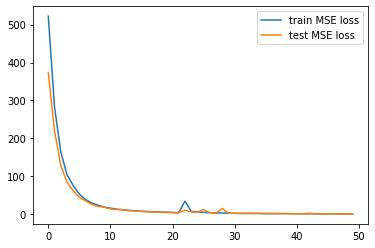

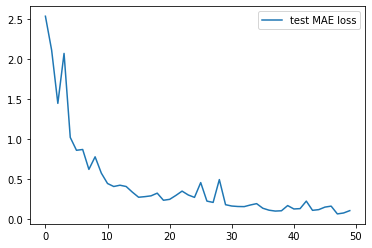

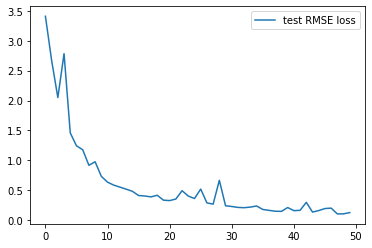

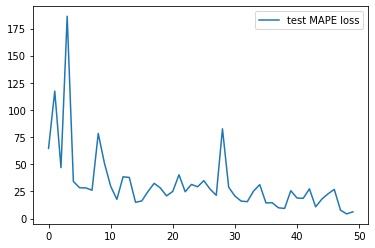

In [60]:
for epoch in range(max_epoch_num):
    mse_train = train_epoch(net, train_dataset, device)
    g_MSE_list_train.append(float(mse_train))
    print('Train Epoch: %d, Loss(MSE): %.4f' % (epoch, mse_train))

    mse_test, mae_test, rmse_test, mape_test = test_epoch(net, test_dataset, device)
    g_MSE_list_test.append(float(mse_test))
    g_MAE_list_test.append(mae_test)
    g_RMSE_list_test.append(rmse_test)
    g_MAPE_list_test.append(mape_test)
    print('Test Epoch: %d, Loss(MSE): %.4f, RMSE: %.4f, MAE: %.4f, MAPE: %.4f' % 
    (epoch, mse_test, mae_test, rmse_test, mape_test))


plt.plot(g_MSE_list_train, label='train MSE loss')
plt.plot(g_MSE_list_test, label='test MSE loss')
plt.legend() 
plt.show()     

plt.plot(g_MAE_list_test, label='test MAE loss')
plt.legend() 
plt.show()     

plt.plot(g_RMSE_list_test, label='test RMSE loss')
plt.legend() 
plt.show()   

plt.plot(g_MAPE_list_test, label='test MAPE loss')
plt.legend() 
plt.show() 